In [1]:
import numpy as np
import matplotlib.pyplot as plt        

In [2]:
%%capture
#%pylab nbagg

from tvb.simulator.lab import *

In [3]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors=prop_cycle.by_key()['color']

In [4]:
from matplotlib.lines import Line2D

def phase_plane(
        model, 
        variables=None, 
        npoints=100, 
        state=None, 
        mode=0,
        title=None,
        square_aspect=False,
        faded=False,
        ax=None
):
    assert len(model.state_variables) > 1
    if ax is None:
        _, ax = plt.subplots(figsize=(4.25,4))

    if faded:
        color="k"
        alpha=0.5
    else:
        color=None
        alpha=1

    if variables==None:
        svarx, svary = [0,1]
        variables = model.state_variables[:2]
    else:
        assert len(variables) == 2
        svarx = model.state_variables.index(variables[0])
        svary = model.state_variables.index(variables[1])

    if state is None:
        state = np.array([model.state_variable_range[key].mean() for key in model.state_variables])
        state = state[:,np.newaxis,np.newaxis]

    if title is None:
        title='' #model.__class__.__name__


    xlim = model.state_variable_range[variables[0]]
    ylim = model.state_variable_range[variables[1]]

    x = np.linspace( *xlim, npoints)
    y = np.linspace( *ylim, npoints)

    xx, yy = np.meshgrid(x,y)
    dx = np.zeros([len(y),len(x)])
    dy = np.zeros([len(y),len(x)])


    nocoupling = np.zeros(( model.nvar, 1, model.number_of_modes))
    for i in range(len(y)):
        for j in range(len(x)):
            state[svarx,0,:] = x[j]
            state[svary,0,:] = y[i]
            dstate = model.dfun(
                    state,
                    nocoupling
            )
            dx[i,j], dy[i,j] = dstate[[svarx,svary],0,mode]
    ax.streamplot(x,y,dx,dy,density=0.75,color='lightgray')

    ax.set_xlabel(variables[0],fontsize=18.0)
    ax.set_ylabel(variables[1],fontsize=18.0)
    ax.contour(xx,yy,dx, [0], colors=colors[1], alpha=alpha)
    ax.contour(xx,yy,dy, [0], colors=colors[2], alpha=alpha)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(labelsize=14)
    legend_elements = [
            Line2D([0], [0], color=colors[1], alpha=alpha, label=f'$\dot {variables[0]}=0$'),
            Line2D([0], [0], color=colors[2], alpha=alpha, label=f'$\dot {variables[1]}=0$'),
    ]
    #ax.legend(handles=legend_elements,loc='upper right',fontsize=16+2)
    ax.set_title(title,fontsize=20)
    if square_aspect:
        ax.set_aspect(abs(xlim[0]-xlim[1])/abs(ylim[0]-ylim[1]))
    plt.tight_layout()

    return ax

In [5]:
def configure_single_node_sim(
    model,
    initial_conditions=None,
    sim_len=100,
    deterministic=False,
    noise_sigma=0.01,
    dt=0.01,
):
    """ Configures a single node simulation.

    Parameters
    sim_len        length [ms] of simulation
    deterministic  no noise if set to True (default True)
    dt             integration step (default 0.01)

    Returns:
    sim            configured simulator instance
    """

    conn = connectivity.Connectivity()
    conn.weights=np.zeros((2,2))
    conn.tract_lengths=np.zeros((2,2))
    conn.centres=np.zeros((2,3))
    conn.number_of_regions=2
    conn.region_labels = np.array(["A","ignore"])

    con_coupling = coupling.Scaling()

    if deterministic:
        integrator = integrators.RungeKutta4thOrderDeterministic(dt=dt)
    else:
        nsigma = noise_sigma
        hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]))
        integrator = integrators.HeunStochastic(dt=dt, noise=hiss)

    mntrs = [monitors.Raw()]

    if initial_conditions is not None:
        initial_conditions = np.stack(
                [initial_conditions,initial_conditions],
                axis=1
        )[np.newaxis,:,:, np.newaxis]

    sim = simulator.Simulator(model=model,
                              connectivity=conn,
                              coupling=con_coupling,
                              integrator=integrator,
                              monitors=mntrs,
                              simulation_length=sim_len)
    if initial_conditions is not None:
        sim.initial_conditions = initial_conditions

    sim.configure()

    return sim

## Neural Mass Model 

Montbrió E, Pazó D, Roxin A. Macroscopic description for networks of spiking neurons. Physical Review X. 2015;5(2):21028.

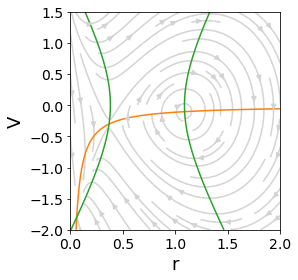

In [6]:
T2d = models.MontbrioPazoRoxin()
T2d.Delta=np.asarray([0.7]);
T2d.eta=np.asarray([-4.6]);
T2d.J=np.asarray([14.5]);
T2d.I=np.asarray([0.5]);
phase_plane(T2d);
#plt.savefig('PP05.pdf')

In [7]:
# Configure the simulator for a deterministic simulation (i.e., without noise)
sim = configure_single_node_sim(
    T2d, 
    sim_len=75,
    initial_conditions=np.r_[0,-2],
    deterministic=True
)

In [8]:
# Configure stimulation as sinusoidal input in the membrane potential

eqn_t = equations.Sinusoid()
eqn_t.parameters['amp'] = 3.
eqn_t.parameters['frequency'] = 1/40.
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(sim.connectivity.number_of_regions)
)

sim.stimulus = stimulus
sim.configure();

In [16]:
# Run the simulation
(raw_time, raw_data), = sim.run()

In [26]:
r = raw_data[:,0,0,0]
V = raw_data[:,1,0,0]

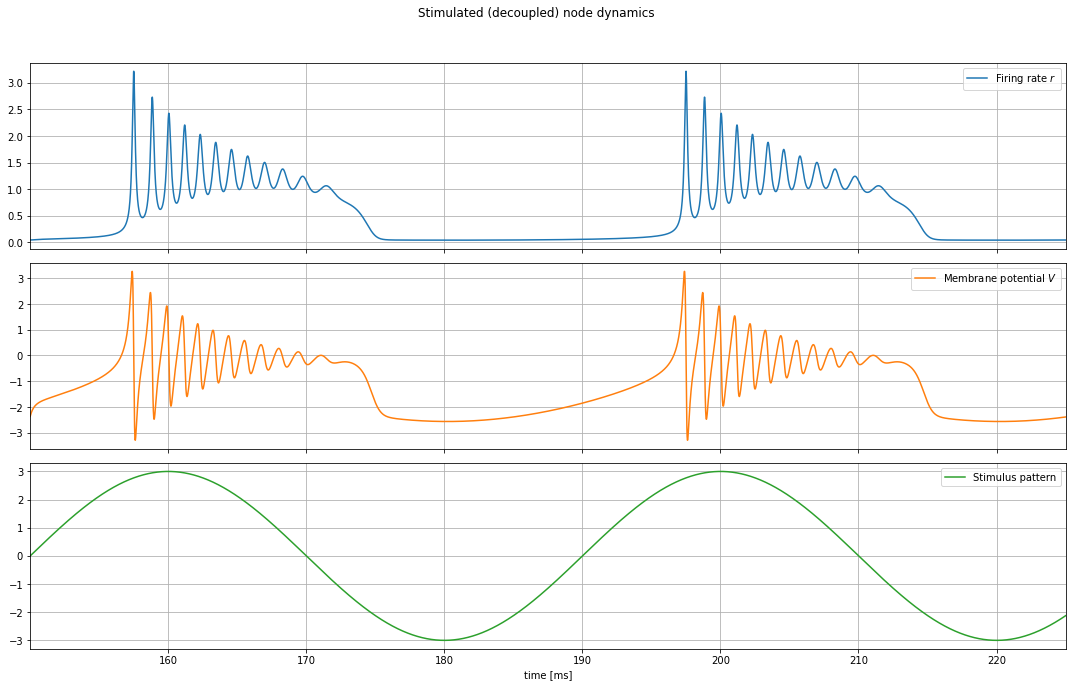

In [35]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
pattern = sim.stimulus.temporal_pattern[0]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, (var, label) in enumerate([(r,'Firing rate $r$'), (V,'Membrane potential $V$'), (pattern,'Stimulus pattern')]):
    ax = axs[i]
    ax.plot(raw_time, var, label=label, c=colors[i])
    ax.set_xlim((raw_time[0],raw_time[-1]))
    ax.legend()
    ax.grid()
axs[-1].set_xlabel('time [ms]')

fig.suptitle('Stimulated (decoupled) node dynamics')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()